# Building Deep Neural Network :: Fully Connected Layer

해당 스크립트에서는 기본적인 Fully Connected Layer라고 불리는 기본적인 Neural Network를 numpy를 이용하여 구현하도록 하겠습니다.

- 시작하기 앞서서 먼저 forward/Activation/Softmax/MSE Cost/Gradient Descent에 대해서 먼저 설명합니다.

- 해당 모듈을 확인하고 나면, 이를 연결하여 하나의 Fully Connected Layer를 만듭니다.

## 1 - MNIST Data Load 

먼저, 예제 데이터를 입력으로 사용하기 위해서 MNIST 데이터를 로드합니다.

In [33]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


In [30]:
# MNIST Data Load
def read_data(label_path, image_path):
    with gzip.open(label_path) as flbl:
        _, _ = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image_path, 'rb') as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

In [31]:
path = "data/"
(train_label, train_img) = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_label, val_img) = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

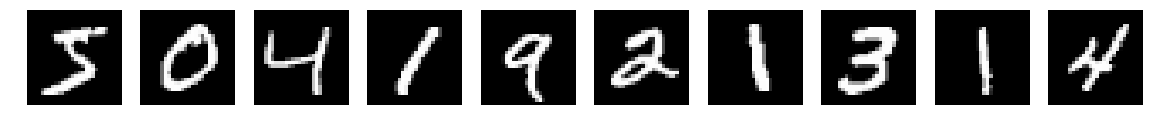

In [42]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')

plt.show()

train_label = train_label.astype(np.int64)
train_img = train_img.astype(np.float32) / 255
val_label = val_label.astype(np.int64)
val_img = val_img.astype(np.float32) / 255

## 2 - Forward Operation

1. 먼저 입력 데이터의 차원에 맞게, 가중치 행렬을 생성하고 초기화합니다.
2. 초기화된 Weights와 bias를 입력 데이터와 Linear 연산을 통해서 Weights Sum을 진행합니다.
3. 그 이후, ACTIVATION (Sigmoid, ReLU etc)를 이용해서 최종 출력을 얻습니다.


<img src="images/perceptron.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 1</u>: Forward Operation. <br> The model can be summarized as: ***[INPUT -> LINEAR -> ACTIVATION]***</center></caption>

<br/>
위의 그림을 수식으로 일반화하면, 아래와 같습니다
<br/><br/>

<table style="width:100%">


    <tr>
        <td>  </td> 
        <td> **Shape of W** </td> 
        <td> **Shape of b**  </td> 
        <td> **Activation** </td>
        <td> **Shape of Activation** </td> 
    <tr>
    
    <tr>
        <td> **Layer 1** </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    
    <tr>
        <td> **Layer 2** </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
   
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>
    
   <tr>
        <td> **Layer L-1** </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
    
    
   <tr>
        <td> **Layer L** </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>

</table>

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

### 2-1. Initialization

- 데이터 차원에 맞게 가중치 행렬을 생성하고 초기화합니다.
- 일반적으로 weights는 난수로, bias는 0으로 초기화합니다.

In [35]:
# GRADED FUNCTION: initialize_parameters

def basic_initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [36]:
parameters = basic_initialize_parameters(2,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]]
b1 = [[ 0.]
 [ 0.]]
W2 = [[ 0.00865408 -0.02301539]]
b2 = [[ 0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> **W1** </td>
    <td> [[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]] </td> 
  </tr>

  <tr>
    <td> **b1**</td>
    <td>[[ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[ 0.00865408 -0.02301539]]</td>
  </tr>
  
  <tr>
    <td> **b2** </td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>

In [50]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):    
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))        
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [40]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[ 0.]
 [ 0.]
 [ 0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> **W1** </td>
    <td>[[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]</td> 
  </tr>
  
  <tr>
    <td>**b1** </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td>**W2** </td>
    <td>[[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]</td> 
  </tr>
  
  <tr>
    <td>**b2** </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
</table>

### 2-2. Linear Forward Module

Linear Forward Module은 아래와 같은 수식으로 일반화되어 계산됩니다.

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 
<br/>
<br/>

In [41]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [59]:
X = train_img[0]
print("X's dimensions : {}".format(X.shape), end="\n\n")

parameters = initialize_parameters_deep([28,28,1])
print("key of parameters : {}".format(parameters.keys()), end="\n\n")
A, W, b = X, parameters["W1"], parameters["b1"]
Z, linear_cache = linear_forward(X, W, b)

print("Z[0] = " + str(Z[0]))

X's dimensions : (28, 28)

key of parameters : dict_keys(['b2', 'W1', 'b1', 'W2'])

Z[0] = [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.94962319e-03  -8.56088005e-03  -7.01055263e-03   9.21223156e-04
  -1.40779296e-03   7.28034138e-04  -5.37452855e-05  -5.59312440e-03
  -5.34447205e-03   6.72926288e-03  -7.75971334e-03  -1.84216995e-02
  -2.45760235e-02  -4.69203890e-02  -3.32101138e-02  -2.23488248e-02
  -8.95088092e-03  -5.70976535e-03  -5.02796410e-03  -1.97450375e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


**Expected output**:
       
<table style="width:100%">
  <tr>
    <td> **Z[0]** </td>
    <td>[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.94962319e-03  -8.56088005e-03  -7.01055263e-03   9.21223156e-04
  -1.40779296e-03   7.28034138e-04  -5.37452855e-05  -5.59312440e-03
  -5.34447205e-03   6.72926288e-03  -7.75971334e-03  -1.84216995e-02
  -2.45760235e-02  -4.69203890e-02  -3.32101138e-02  -2.23488248e-02
  -8.95088092e-03  -5.70976535e-03  -5.02796410e-03  -1.97450375e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]</td> 
  </tr>
</table>

### 2-3. Linear-Activateion Forward

이번 예제에서는 2가지 종류의 Activation function을 사용합니다.


- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. `sigmoid` 함수는 **2개**의 return 값을 갖습니다. : activation value "`a`", ""`Z`"를 포함하고 있는 `cache`" (Backpropagation때, 이를 사용합니다). 사용법은 다음과 같습니다: 
``` python
A, activation_cache = sigmoid(Z)
```

<img src="images/sigmoid.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 2</u>: Sigmoid.</center></caption>

- **ReLU**: 수학적 공식은 다음과 같습니다. $A = ReLU(Z) = max(0, Z)$. `relu` 함수는 **2개**의 return값을 갖습니다. : the activation value "`A`", `Z`를 포함하고 있는"`cache`""" (Backpropagation때, 이를 사용합니다). 사용법은 다음과 같습니다:
``` python
A, activation_cache = relu(Z)
```
<img src="images/relu.jpeg" style="width:650px;height:300px;">
<caption><center> <u>Figure 3</u>: ReLU.</center></caption>

- **Derivative of Sigmoid**: <br/> $g'(Z) = \frac{ d }{ dz }\frac{ 1 }{ 1+e^{-z} } = \frac{1}{(1+e^-z)^2}(e^{-z}) = \frac{1}{1+e^{-z}}(1-\frac{1}{1+e^{-z}}) = g(z)(1-g(z))$<br/><br/>

- **Derivative of ReLU**: <br/> $g'(Z) = \max(0, Z)$

In [75]:
def derivative_sigmoid(Z):
    return (1/(1+np.exp(-Z)) * (1-1/(1+np.exp(-Z))))

def derivative_relu(Z):
    pass

def sigmoid(Z):
    return 1/(1+np.exp(-Z)), derivative_sigmoid(Z)

def relu(Z):
    return np.maximum(0, Z), np.maximum(0, Z)

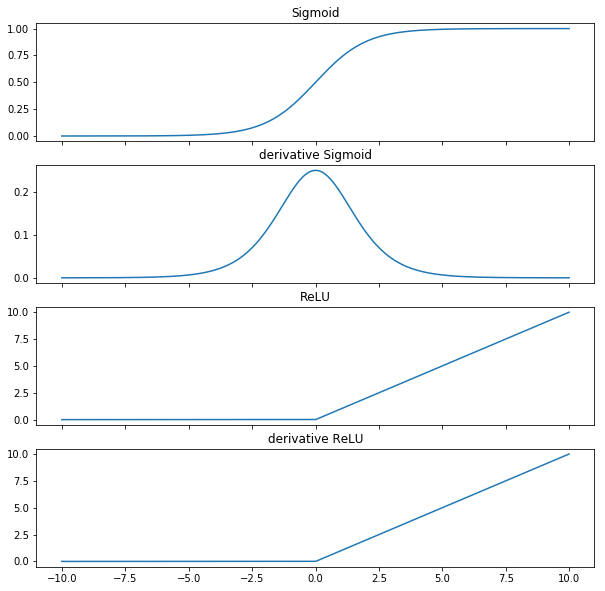

In [77]:
tmp = [round(i*0.01, 5) for i in range(-1000,1000)]
x = np.asarray(tmp)


f, axarr = plt.subplots(4, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)
sig, derivate_sig = sigmoid(x)
ReLU, derivate_relu = relu(x)
axarr[0].plot(x, sig)
axarr[0].set_title("Sigmoid")
axarr[1].plot(x, derivate_sig)
axarr[1].set_title("derivative Sigmoid")
axarr[2].plot(x, ReLU)
axarr[2].set_title("ReLU")
axarr[3].plot(x, derivate_relu)
axarr[3].set_title("derivative ReLU")

In [78]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [80]:
X = train_img[0]
print("X's dimensions : {}".format(X.shape), end="\n\n")

parameters = initialize_parameters_deep([28,28,1])
print("key of parameters : {}".format(parameters.keys()), end="\n\n")
A_prev, W, b = X, parameters["W1"], parameters["b1"]

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="sigmoid")
print("With sigmoid: A[0] = " + str(A[0]))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="relu")
print("With ReLU: A[0] = " + str(A[0]))

X's dimensions : (28, 28)

key of parameters : dict_keys(['b2', 'W1', 'b1', 'W2'])

With sigmoid: A[0] = [ 0.5         0.5         0.5         0.5         0.4987626   0.49785979
  0.49824737  0.50023031  0.49964805  0.50018201  0.49998656  0.49860172
  0.49866389  0.50168231  0.49806008  0.49539471  0.4938563   0.48827205
  0.49169823  0.49441303  0.49776229  0.49857256  0.49874301  0.49950637
  0.5         0.5         0.5         0.5       ]
With ReLU: A[0] = [ 0.          0.          0.          0.          0.          0.          0.
  0.00092122  0.          0.00072803  0.          0.          0.
  0.00672926  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]


**Expected output**:
       
<table style="width:100%">
  <tr>
    <td> **With sigmoid: A[0] ** </td>
    <td > [ 0.5         0.5         0.5         0.5         0.4987626   0.49785979
  0.49824737  0.50023031  0.49964805  0.50018201  0.49998656  0.49860172
  0.49866389  0.50168231  0.49806008  0.49539471  0.4938563   0.48827205
  0.49169823  0.49441303  0.49776229  0.49857256  0.49874301  0.49950637
  0.5         0.5         0.5         0.5       ]</td> 
  </tr>
  <tr>
    <td> **With ReLU: A[0] ** </td>
    <td > [ 0.          0.          0.          0.          0.          0.          0.
  0.00092122  0.          0.00072803  0.          0.          0.
  0.00672926  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]</td> 
  </tr>
</table>

### 2-4. L-Layer Model

이전까지 간단한 Forward Operation이 어떻게 구성되는지 확인하였습니다.<br/>
이러한 Forward Operation을 여러번 진행하게되면, 이것이 Deep Neural Network가 됩니다.<br/>

이번 코드에서는 SIGMOID ACTIVATION을 이용한 Muli Layer Forward Operation에 대해서 알아보겠습니다.

<img src="images/model_architecture_kiank.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 4</u>: L-Layer Model.</center></caption>

**Note**: 이번 코드에서 다시 한번 Linear-Activation 수식을 언급하겠습니다.<br/>
$A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (마지막 출력의 경우 출력값의 표현을 `Yhat`이라고 합니다, i.e., 수식적으로 표현하면 다음과 같습니다. $\hat{Y}$.)

In [81]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

In [82]:
X, parameters = train_img[0], initialize_parameters_deep([28,28,1])
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[ 0.5         0.5         0.5         0.5         0.50000488  0.49999259
   0.49999292  0.50006658  0.50019038  0.50018837  0.5000768   0.50000425
   0.50000441  0.49996328  0.49990328  0.49989251  0.49988565  0.50000674
   0.49992422  0.49995059  0.49978186  0.49970537  0.4997401   0.49989355
   0.5         0.5         0.5         0.5       ]]
Length of caches list = 2


<table style="width:100%">
  <tr>
    <td> **AL** </td>
    <td > [[ 0.5         0.5         0.5         0.5         0.50000488  0.49999259
   0.49999292  0.50006658  0.50019038  0.50018837  0.5000768   0.50000425
   0.50000441  0.49996328  0.49990328  0.49989251  0.49988565  0.50000674
   0.49992422  0.49995059  0.49978186  0.49970537  0.4997401   0.49989355
   0.5         0.5         0.5         0.5       ]]</td> 
  </tr>
  <tr>
    <td> **Length of caches list ** </td>
    <td > 2</td> 
  </tr>
</table>

## 3 - Cost Function

지금까지 Muli Layer Forward Operation을 구현하였습니다.

이번엔 Forward Operation의 결과와 label 값을 통해서 나온 결과를 비교해서 비용함수를 정의하도록 하겠습니다.

**Exercise**: 여기서는 cross-entropy cost $J$를 계산합니다, 수식은 다음과 같습니다.: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

**Why Cross-entropy Cost?**: MSE(Mean Squared Error)의 경우네는 틀린 샘플에 대해서 더 집중하는 특징을 갖습니다. 틀린 것과 맞은 것에 대해서 똑같이 집중해서 Loss를 전파해줘야하는데, 틀린 부분에 대해서만 Loss를 전파하기 때문에 학습이 덜 되는 경향이 있습니다

만약에 네트워크가 다음과 같은 2가지 결과를 주었다고 가정해 보겠습니다.

**1-th network**
<table style="width:50%", title="1-th network">
  <tr>
    <td> **계산결과** </td>
    <td> **라벨(A/B/C)** </td>
    <td> **Correct?** </td>
  </tr>
  <tr>
    <td> 0.3  0.3  0.4 </td>
    <td > 0  0  1 (A) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.3  0.4  0.3 </td>
    <td > 0  1  0 (B) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.1  0.2  0.7 </td>
    <td > 1  0  0 (C) </td> 
    <td > no </td> 
  </tr>
</table>
**2-th network**
<table style="width:50%", title="2-th network">
  <tr>
    <td> **계산결과** </td>
    <td> **라벨(A/B/C)** </td>
    <td> **Correct?** </td>
  </tr>
  <tr>
    <td> 0.1  0.2  0.7 </td>
    <td > 0  0  1 (A) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.1  0.7  0.2 </td>
    <td > 0  1  0 (B) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.3  0.4  0.3 </td>
    <td > 1  0  0 (C) </td> 
    <td > no </td> 
  </tr>
</table>



위 결과에 대해서 오차를 계산해보겠습니다.

**1. 분류 오차**
- *1-th network*:
 - 분류오차 -> $$\frac{1}{3} = 0.33$$ (3개의 샘플 중에 1개가 라벨과 일치하지 않으므로)
 - 분류 정확도 -> $$\frac{2}{3} = 0.67$$
<br/><br/>

- *2-th network*:
 - 분류오차 -> $$\frac{1}{3} = 0.33$$ (3개의 샘플 중에 1개가 라벨과 일치하지 않으므로)
 - 분류 정확도 -> $$\frac{2}{3} = 0.67$$

두 오차에 대해서 비교해보면, 결과는 같지만, 2-th 네트워크의 첫 두 샘플은 1-th 네트워크보다 조금 더 확실히 맞추었고, 세번째 샘플은 아깝게 틀렸습니다.

이러한 결과를 보았을 때, 단순 분류 오차의 계산은 틀린 개수에 대한 결과만 줄 뿐 label과 비교해서 얼마나 많이 틀렸는지 얼마나 정확하게 맞았는지 그 정도에 대한 값을 제공하지 않습니다

**2. MSE(Mean Squared Error)**

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n}{(\hat{Y_{i}} - Y_{i})^{2}}$

<br/>
- *1-th network*:
 - 분류오차 -> $(0.3-0)^{2} + (0.3-0)^{2} + (0.4-1)^{2} = 0.54$ (나머지 2개의 샘플에 대해서는 생략..)
 - 분류 정확도 -> $\frac{(0.54 + 0.54 + 1.34)}{3} = 0.81$
<br/><br/>

- *2-th network*:
 - 분류오차 -> (생략...)
 - 분류 정확도 -> $\frac{(0.14 + 0.14 + 0.74)}{3} = 0.34$

**3. Cross-entropy Error**

$-\frac{1}{m}\sum\limits_{i = 1}^{m}(\hat{Y_{i}}\log\left(Y_{i}\right) + (1-\hat{Y_{i}})\log\left(1- Y_{i}\right))$

<br/>
- *1-th network*:
 - 분류오차 -> $(0.3-0)^{2} + (0.3-0)^{2} + (0.4-1)^{2} = 0.54$ (나머지 2개의 샘플에 대해서는 생략..)
 - 분류 정확도 -> $\frac{(0.54 + 0.54 + 1.34)}{3} = 0.81$
<br/><br/>

- *2-th network*:
 - 분류오차 -> (생략...)
 - 분류 정확도 -> $\frac{(0.14 + 0.14 + 0.74)}{3} = 0.34$
